## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images and the ancillary data (satellite data, soil data, climate data etc.) to predict the 6 plant properties.

**CHANGELOG**:

v1 -> v2: 
1. Replaced EfficientNet V1 with V2
2. Removed the rescaling layer prior to EfficientNet. This layer was erroneously included.

v2 -> v3:
Increased the number of training epochs (10 -> 15)

v3 -> v4:
1. Further Increased the number of training epochs (15 -> 25)
2. Set the number of warmup steps as a percentage (20%) of the total number of optimization steps

v4 -> v5:
Dropping highly correlated features in the tabular data through hierarchical clustering

v5 -> v10:
1. Training ensembles of models
2. Reducing the number of training epochs for each model in the ensemble (25 -> 15)


v10 -> v11:
1. Replaced EfficientNetV2B0 with EfficientNetV2B1 (larger model)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
import keras
from keras.applications.efficientnet_v2 import EfficientNetV2B1, preprocess_input

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

In [6]:
## global configuration
CFG = {
    'N_SPLITS': 5,
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 15,
    'MAX_LR': 5e-4,
    'WARMUP_PCT': 0.2,
    'n_tabular_layers': 2,
    'img_backbone_final_dim': 128,
    'tabular_hsizes': [256, 128],
    'n_ff_layers': 2,
    'ff_hsizes': [128, 64]
}

## Loading the data

In [7]:
import os
path =  os.path.join(os.getcwd() , 'data')
imgs_train = f"{path}/train_images"
imgs_test = f"{path}/test_images"

train =pd.read_csv(path  +  '/train.csv')
train['img_path'] = path + "/train_images/" + train["id"].astype(str) + ".jpeg"   # add images in the training dataframe

test = pd.read_csv(path  +  '/test.csv')
test['img_path'] =  path + "/test_images/" + test["id"].astype(str) + ".jpeg"   # add images in the training dataframe

In [8]:
targets = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean' ,'X50_mean', 'X3112_mean']
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean_mean',
 'X11_mean_mean',
 'X18_mean_mean',
 'X26_mean_mean',
 'X50_mean_mean',
 'X3112_mean_mean']

In [9]:
# remove sd columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

KeyError: "['X4_mean_sd', 'X11_mean_sd', 'X18_mean_sd', 'X26_mean_sd', 'X50_mean_sd', 'X3112_mean_sd'] not found in axis"

## Preprocessing

In [ ]:
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols)
Y = train[target_cols]

In [ ]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 4680


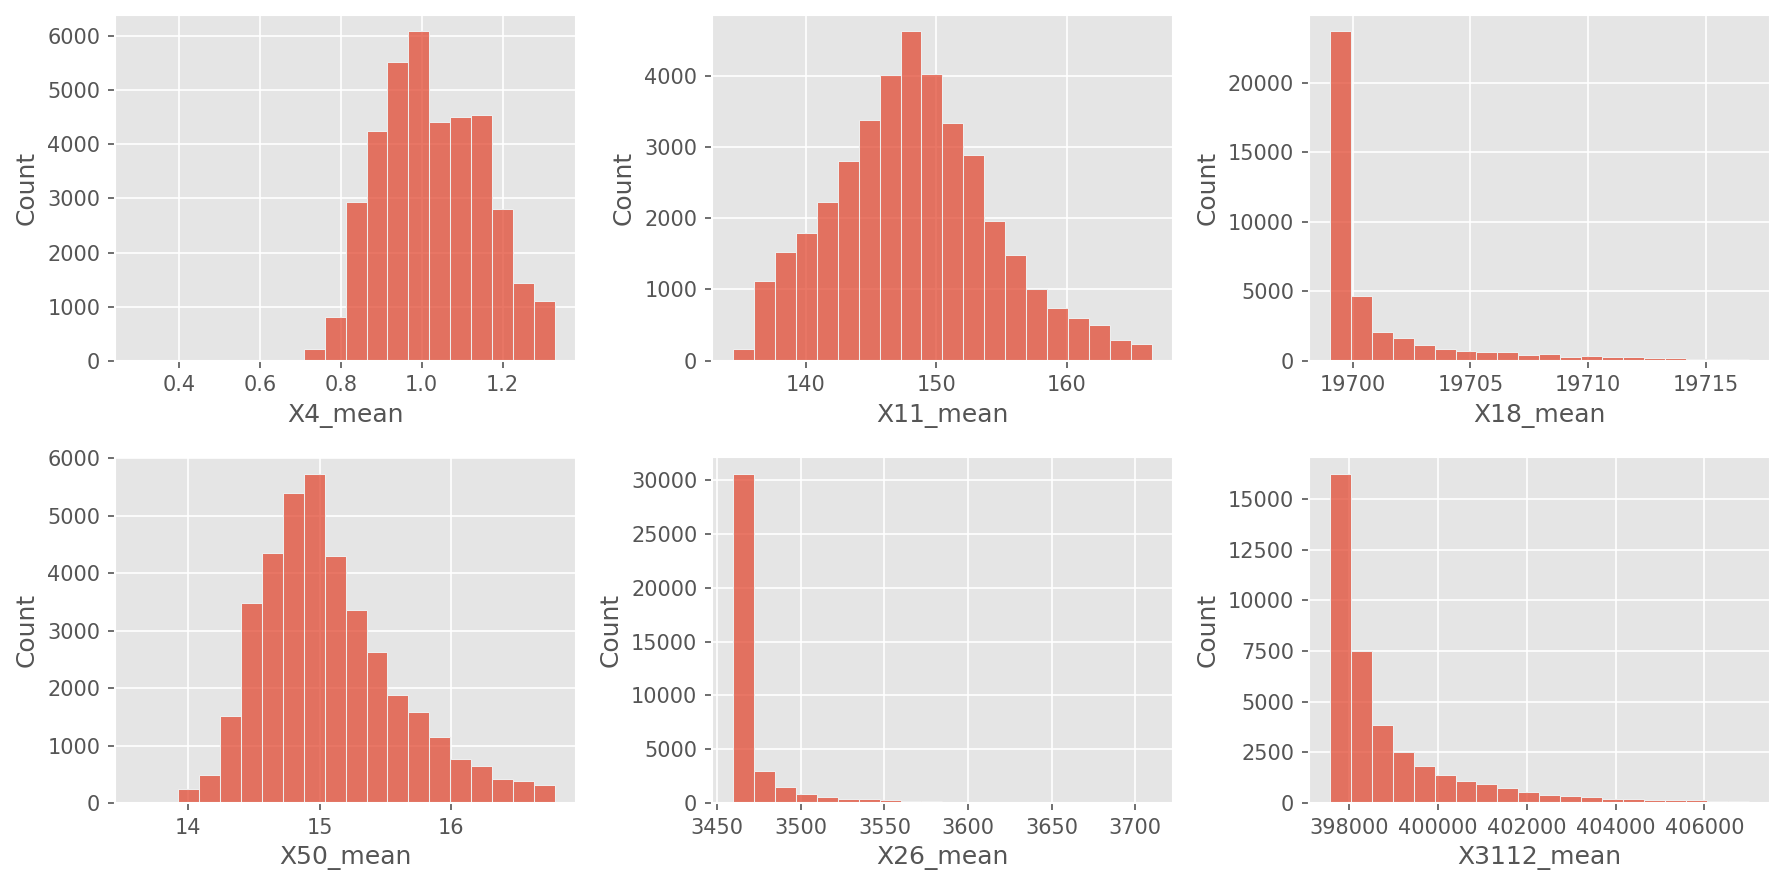

In [ ]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [ ]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)
_ = joblib.dump(output_sc, 'output_scaler.pkl')

(38683, 6)

## Tabular preprocessing

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [ ]:
# construct correlation matrix
corr_matrix = tabular.corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

In [ ]:
tabular.columns

Index(['VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO1_annual_mean_temperature',
       'SOIL_cfvo_0.5cm_mean_0.01_deg', 'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_ocd_100.200cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflecta

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

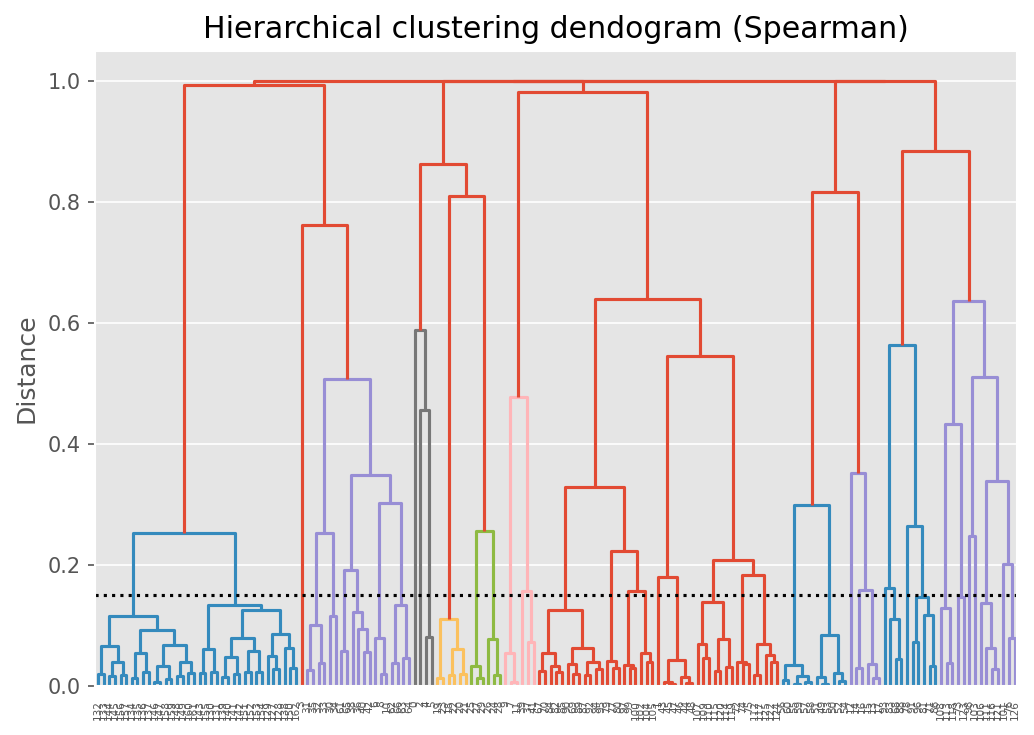

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
#     labels=corr_matrix.columns.tolist(),
)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
_ = ax.axhline(0.15, 0, 1, linestyle='dotted', color='k')
_ = ax.grid(False, axis='x')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depend on the distance we use as threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15. 

In [ ]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

Number of clusters: 43



In [ ]:
import json
cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    #print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    #print(cluster_features[label])
    #print()
    
with open('feature_clusters.json', 'w') as f:
    json.dump(cluster_features, f)

Finally, we will select only one feature from each cluster. 

In [ ]:
final_features = []
for cols_in_cluster in cluster_features.values():
    final_features.append(cols_in_cluster[0])
    
tabular = tabular[final_features]

For the select features, we will apply min-max normalization. 

In [ ]:
# normalize tabular inputs
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular).astype(np.float32)
_ = joblib.dump(tabular_input_sc, 'tabuler_input_scaler.pkl')

array([[0.6193402 , 0.5535968 , 0.03189493, ..., 0.54300636, 0.5473258 ,
        0.5648345 ],
       [0.463563  , 0.45229077, 0.01688555, ..., 0.44409987, 0.4214611 ,
        0.46729735],
       [0.61859787, 0.6853938 , 0.06566604, ..., 0.17023014, 0.14948541,
        0.16033274],
       ...,
       [0.24186118, 0.18247332, 0.03377111, ..., 0.31581524, 0.32950902,
        0.32816833],
       [0.4096464 , 0.42284995, 0.06316448, ..., 0.4117839 , 0.38653618,
        0.42342195],
       [0.665002  , 0.4748542 , 0.0412758 , ..., 0.36836952, 0.32157922,
        0.32327515]], dtype=float32)

## Image preprocessing functions

In [ ]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing for efficient net 
    # per documentation, does nothing; including it
    # here for consistency
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets

def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

## Model architecture

In [ ]:
def create_model(backbone, num_steps_per_epoch):

    ############################## 
    # IMG Processing
    ############################## 
    img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")

    img_backbone = keras.Sequential([
        # augmentation layers
        keras.Sequential([
            keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
            keras.layers.RandomTranslation(
                height_factor=0.1, width_factor=0.1, interpolation='nearest'
            ),
            keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
            keras.layers.RandomFlip(mode="horizontal_and_vertical")
        ], name='augmentation'),
        #### Efficientnet backbone ####
        backbone,
        ###############################
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(CFG['img_backbone_final_dim'])
    ], name='img_backbone')

    # fix efficientnet weights 
    img_backbone.get_layer('efficientnetv2-b1').trainable = False

    img_output = img_backbone(img_input)

    ############################## 
    # Tabular Processing
    ##############################
    tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")

    backbone_blocks = []
    for i in range(CFG['n_tabular_layers']):
        backbone_blocks.extend([
            keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'tabular_block_{i}_dense'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dropout(0.1)
        ])

    tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
    tabular_output = tabular_backbone(tabular_input)

    ##############################
    # Concat and outputs
    ##############################
    output = keras.layers.Concatenate()([img_output, tabular_output])
    for i in range(CFG['n_ff_layers']):
        output = keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'ff_block_{i}_dense')(output)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.ReLU()(output)
        output = keras.layers.Dropout(0.1)(output)


    output = keras.layers.Dense(6, name='output')(output)

    model = keras.Model(inputs=[img_input, tabular_input], outputs=output)


    num_steps_per_epoch = num_steps_per_epoch
    total_steps = CFG['NUM_EPOCHS'] * num_steps_per_epoch
    warmup_steps = np.ceil(CFG['WARMUP_PCT'] * total_steps).astype(int)


    lr_scheduler = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = 1e-5,
        decay_steps = total_steps - warmup_steps,
        warmup_target= CFG['MAX_LR'],
        warmup_steps = warmup_steps
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
        loss= keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.R2Score()]
    )
    
    return model

## Training the ensemble models

In [ ]:
# keras.backend.clear_session()

# # download the weights
# efficientnet_backbone = EfficientNetV2B1(include_top=False, weights='imagenet')
# # fix efficientnet weights
# efficientnet_backbone.trainable = False


# models_ensemble = [None] * CFG['N_SPLITS']
# histories = [None] * CFG['N_SPLITS']
# CV_splitter = KFold(n_splits=CFG['N_SPLITS'], random_state=1, shuffle=True)
# Y_cv_pred = Y_sc.astype(np.float32).copy()

# for i, (idxs_train, idxs_val) in enumerate(CV_splitter.split(tabular_sc)):
#     print(f'******************** Processing split {i + 1} ********************')
    
#     # training split
#     paths_train = img_paths[idxs_train,...]
#     tabular_train = tabular_sc[idxs_train,...]
#     Y_train = Y_sc[idxs_train,...]
    
#     # validation split
#     paths_val = img_paths[idxs_val,...]
    tabular_val = tabular_sc[idxs_val,...]
#     Y_val = Y_sc[idxs_val,...]
    
#     # datasets with targets
#     train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
#     val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))
    
#     train_ds = train_ds.map(process_path).batch(CFG['BATCH_SIZE'])
#     val_ds = val_ds.map(process_path).batch(CFG['BATCH_SIZE'])
    
#     # train model
#     models_ensemble[i] = create_model(efficientnet_backbone, len(train_ds))
#     histories[i] = models_ensemble[i].fit(train_ds, validation_data=val_ds, epochs=CFG['NUM_EPOCHS'])
    
#     # save weights
#     models_ensemble[i].save_weights(f"model_split{i+1}.weights.h5")
    
#     # compute out-of-fold predictions
#     val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
#     val_ds = val_ds.map(process_paths_wo_targets).batch(256)
    
#     # Y_cv_pred[idxs_val, :] = models_ensemble[i].predict(val_ds)

2024-08-07 21:56:06.337802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22488 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-08-07 21:56:06.338253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15393 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
******************** Processing split 1 ********************
Epoch 1/15


2024-08-07 21:56:21.976611: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905
W0000 00:00:1723082182.093957   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.121955   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.123065   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.130901   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.132734   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.134670   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.136656   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082182.138449   37486 gpu_t

241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.6481 - r2_score: -0.6412

W0000 00:00:1723082208.051040   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.051964   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.052810   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.053691   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.054565   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.055443   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.056319   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.057694   37474 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082208.059077   37474 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.6472 - r2_score: -0.6403

W0000 00:00:1723082216.038480   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.039202   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.039862   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.040547   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.041229   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.041902   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.042573   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.043532   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.044491   37478 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - loss: 1.6464 - r2_score: -0.6394 - val_loss: 0.9337 - val_r2_score: 0.0572
Epoch 2/15
  1/242 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - loss: 1.2755 - r2_score: -0.1075

W0000 00:00:1723082216.441406   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.442337   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.443182   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.444150   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.445001   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.445801   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.446549   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.447466   37478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082216.448274   37478 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - loss: 1.0721 - r2_score: -0.0678 - val_loss: 0.8315 - val_r2_score: 0.1607
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.9199 - r2_score: 0.0839 - val_loss: 0.7785 - val_r2_score: 0.2140
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.8534 - r2_score: 0.1502 - val_loss: 0.7630 - val_r2_score: 0.2297
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.8202 - r2_score: 0.1833 - val_loss: 0.7542 - val_r2_score: 0.2386
Epoch 6/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.8018 - r2_score: 0.2016 - val_loss: 0.7508 - val_r2_score: 0.2421
Epoch 7/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - loss: 0.7872 - r2_score: 0.2161 - val_loss: 0.7436 - val_r2_score: 0.2494
Epoch 8/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.7784 - r2_score: 0.2249 - val_loss: 0.7437 - val_r2_score: 0.2492
Epoch 9/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - loss: 0.7680 - r2_score: 0.2353 - va

W0000 00:00:1723082648.372117   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.373862   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.375489   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.377216   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.378902   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.380592   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.382291   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.385380   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082648.388479   37480 gp

 2/31 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step

W0000 00:00:1723082649.659844   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082649.664498   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082649.669446   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082649.674476   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082649.681313   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723082649.683946   37480 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step
******************** Processing split 2 ********************
Epoch 1/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 1.7077 - r2_score: -0.7078 - val_loss: 0.9883 - val_r2_score: 0.0189
Epoch 2/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 1.0686 - r2_score: -0.0686 - val_loss: 0.8739 - val_r2_score: 0.1328
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.9157 - r2_score: 0.0845 - val_loss: 0.8023 - val_r2_score: 0.2040
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - loss: 0.8526 - r2_score: 0.1476 - val_loss: 0.7831 - val_r2_score: 0.2230
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.8176 - r2_score: 0.1826 - val_loss: 0.7750 - val_r2_score: 0.2310
Epoch 6/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.7962 - r2_score: 0.2040 - val_loss: 0.7696 - val_r2_score: 0.2364
Epoch 7/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 0.7825 - r2_score: 0.2176 - val_loss: 0.7636 -

W0000 00:00:1723083658.799746   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.800680   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.801534   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.802425   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.803317   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.804201   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.805087   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.806505   37475 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083658.807940   37475 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.8796 - r2_score: -0.8671

W0000 00:00:1723083666.891451   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.892195   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.892859   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.893847   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.894831   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.895515   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.896904   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.897588   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083666.898265   37486 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - loss: 1.8783 - r2_score: -0.8658 - val_loss: 0.9629 - val_r2_score: 0.0374
Epoch 2/15
  1/242 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - loss: 1.3193 - r2_score: -0.1317

W0000 00:00:1723083667.295624   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.296605   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.297472   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.298292   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.299056   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.299987   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.300812   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.301811   37486 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723083667.302707   37486 gp

242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - loss: 1.0652 - r2_score: -0.0591 - val_loss: 0.8405 - val_r2_score: 0.1602
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - loss: 0.9015 - r2_score: 0.1039 - val_loss: 0.7929 - val_r2_score: 0.2077
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - loss: 0.8452 - r2_score: 0.1597 - val_loss: 0.7748 - val_r2_score: 0.2258
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.8151 - r2_score: 0.1896 - val_loss: 0.7688 - val_r2_score: 0.2317
Epoch 6/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.8042 - r2_score: 0.2004 - val_loss: 0.7630 - val_r2_score: 0.2376
Epoch 7/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.7895 - r2_score: 0.2150 - val_loss: 0.7592 - val_r2_score: 0.2414
Epoch 8/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.7809 - r2_score: 0.2236 - val_loss: 0.7546 - val_r2_score: 0.2459
Epoch 9/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - loss: 0.7710 - r2_score: 0.2334 - va

## Checking CV output R2

In [ ]:
cv_r2_scores = pd.Series(
    r2_score(Y_sc, Y_cv_pred, multioutput='raw_values'),
    index=target_cols,
)
print(cv_r2_scores)

NameError: name 'Y_sc' is not defined

In [ ]:
print(f'5-fold CV R^2: {cv_r2_scores.mean():.5f}')

5-fold CV R^2: 0.25538


## Predictions on Test Data

In [ ]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(test[final_features]).astype(np.float32)
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)

# compute predictions
predictions = [None] * 5
for i in range(len(models_ensemble)):
    predictions[i] = models_ensemble[i].predict(test_ds)

predictions = np.mean(predictions, axis=0)

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

W0000 00:00:1723084616.314020   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.315703   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.317353   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.318999   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.320645   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.322311   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.323962   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.327009   37476 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723084616.330034   37476 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step


In [ ]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

NameError: name 'pd' is not defined

In [ ]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,154220505,1.116372,145.669693,19708.876953,15.080929,3532.518799,401538.53125
1,195736552,1.050410,148.993927,19701.330078,15.087687,3478.448975,398657.62500
2,182701773,0.944866,149.605560,19699.171875,15.025727,3461.573242,398040.93750
3,27688500,1.008544,143.793701,19699.394531,15.753349,3470.611572,398310.03125
4,195825045,0.949182,150.035385,19699.349609,15.100892,3461.759033,398253.43750
